In [1]:
# Import some packages
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt

np.random.seed(0)

In [2]:
#upload the data 
audio = np.load('spoken_train.npy')
audio_test = np.load('spoken_test.npy') 
written = np.load('written_train.npy')
match_train = np.load('match_train.npy') 
written_test = np.load('written_test.npy')

# Feature engineering

In [3]:
# scale the features for the images 
written = written / 255 

In [4]:
#Find the optimal number of componets for dimensionality reduction for images 
for n_comp in [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80]:
    pca_wr = PCA(n_components = n_comp, random_state = 811)
    pca_wr.fit(written)
    pca_wr.transform(written)
    print("For {} components variance is equal to {}".format(n_comp, np.sum(pca_wr.explained_variance_ratio_)))

For 5 components variance is equal to 0.33191030457929505
For 10 components variance is equal to 0.4877978406990218
For 15 components variance is equal to 0.5787844404286125
For 20 components variance is equal to 0.6429178380139132
For 25 components variance is equal to 0.6910824830514285
For 30 components variance is equal to 0.7298301652366115
For 35 components variance is equal to 0.7604346578718179
For 40 components variance is equal to 0.7853729848646123
For 50 components variance is equal to 0.823968732898441
For 60 components variance is equal to 0.8519698434451212
For 70 components variance is equal to 0.8733386481648396
For 80 components variance is equal to 0.8895525860805874


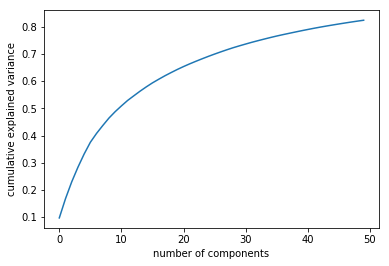

In [5]:
#PCA for images 
pca_wr = PCA(n_components = 50, random_state = 811)
pca_wr.fit(written)
pca_written = pca_wr.transform(written)  

plt.plot(np.cumsum(pca_wr.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [6]:
##Calculate mean,standard deviation, maximum, minimum per feature (out of the 13), per observation.
def audio_features (spoken, functions):
    return np.concatenate([np.array([function(i, axis = 0) for i in spoken]) for function in functions], axis = 1)

summaries = [np.mean, np.max, np.min, np.std]
audio_f = audio_features(audio, summaries)

In [7]:
#merge written and audio data
both = np.hstack((pca_written, audio_f))
both.shape

(45000, 102)

In [8]:
#scale the data 
scaler = StandardScaler()
final = scaler.fit_transform(both)
final.shape

(45000, 102)

# Model

In [9]:
#split the data 
X_train, X_val, y_train, y_val = train_test_split(final, match_train, test_size = 0.1, random_state = 811)

In [10]:
#convert Y into categorical variable
y_train = to_categorical(y_train)
y_val   = to_categorical(y_val)
print(X_train.shape)
print(y_train.shape)

(40500, 102)
(40500, 2)


In [11]:
#Define callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience= 100),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [12]:
#Define the model
def make_model(n_features):
    model = Sequential()
    optimizer = Adam(lr = 0.001)
    
    model.add(Dense(500, input_shape=(final.shape[1],),
              kernel_initializer= 'glorot_normal'))
    model.add(LeakyReLU(alpha=0.3))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(400, kernel_initializer= 'glorot_uniform'))
    model.add(LeakyReLU(alpha=0.01)) 
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(300, kernel_initializer= 'glorot_uniform'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    model.add(Dense(200, kernel_initializer= 'glorot_normal'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    model.add(Dense(2, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer= optimizer,
                  metrics=['accuracy'])

    return model

In [13]:
model = make_model(final.shape[1])
history = model.fit(X_train, y_train, batch_size= 60 , epochs = 200, verbose=1, validation_data = (X_val, y_val), callbacks = callbacks)



Train on 40500 samples, validate on 4500 samples
Epoch 1/200
40500/40500 [==============================] - 7s 175us/sample - loss: 0.3358 - accuracy: 0.8667 - val_loss: 0.2111 - val_accuracy: 0.9236
Epoch 2/200
40500/40500 [==============================] - 6s 151us/sample - loss: 0.1987 - accuracy: 0.9235 - val_loss: 0.1586 - val_accuracy: 0.9410
Epoch 3/200
40500/40500 [==============================] - 5s 119us/sample - loss: 0.1618 - accuracy: 0.9372 - val_loss: 0.1499 - val_accuracy: 0.9444
Epoch 4/200
40500/40500 [==============================] - 5s 116us/sample - loss: 0.1387 - accuracy: 0.9465 - val_loss: 0.1300 - val_accuracy: 0.9494
Epoch 5/200
40500/40500 [==============================] - 5s 124us/sample - loss: 0.1260 - accuracy: 0.9520 - val_loss: 0.1293 - val_accuracy: 0.9539
Epoch 6/200
40500/40500 [==============================] - 5s 135us/sample - loss: 0.1137 - accuracy: 0.9557 - val_loss: 0.1227 - val_accuracy: 0.9586
Epoch 7/200
40500/40500 [====================

40500/40500 [==============================] - 4s 109us/sample - loss: 0.0113 - accuracy: 0.9961 - val_loss: 0.1001 - val_accuracy: 0.9793
Epoch 108/200
40500/40500 [==============================] - 4s 108us/sample - loss: 0.0144 - accuracy: 0.9952 - val_loss: 0.0971 - val_accuracy: 0.9802
Epoch 109/200
40500/40500 [==============================] - 4s 108us/sample - loss: 0.0137 - accuracy: 0.9955 - val_loss: 0.0926 - val_accuracy: 0.9800
Epoch 110/200
40500/40500 [==============================] - 4s 109us/sample - loss: 0.0118 - accuracy: 0.9961 - val_loss: 0.0922 - val_accuracy: 0.9796
Epoch 111/200
40500/40500 [==============================] - 4s 109us/sample - loss: 0.0132 - accuracy: 0.9958 - val_loss: 0.0894 - val_accuracy: 0.9791
Epoch 112/200
40500/40500 [==============================] - 4s 109us/sample - loss: 0.0119 - accuracy: 0.9960 - val_loss: 0.0968 - val_accuracy: 0.9793
Epoch 113/200
40500/40500 [==============================] - 4s 109us/sample - loss: 0.0130 - ac

# Model performance

In [14]:
#print validation accuracy and loss accuracy
score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0]) 
print('Validation accuracy:', score[1])

Validation loss: 0.09188126401005624
Validation accuracy: 0.97933334


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


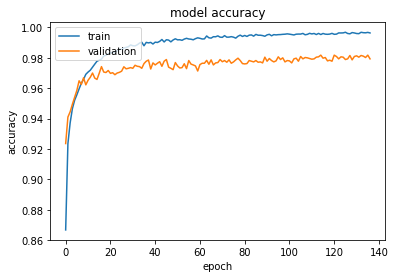

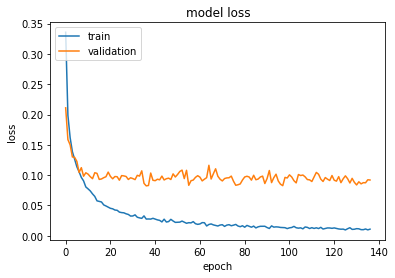

In [15]:
#plot the validation accuracy and validation loss against validation accuracy and training accuracy
print(history.history.keys())

#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [16]:
# examine the class distribution
match_tr = pd.DataFrame(match_train)
def labelling (frame): # this function is to change the True/False label to 1/0
    if frame == False:
        return 0
    else: 
        return 1

In [17]:
match_tr['label'] = match_tr[0].apply(labelling)

In [18]:
match_tr['label'].value_counts() 
# true ~= 10% false, clearly class imbalance so we should keep an eye on this when evaluting

0    40461
1     4539
Name: label, dtype: int64

In [19]:
#make confusion matrix 
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_val)

y_pred = y_pred.argmax(axis = -1)
y_vall  = y_val.argmax(axis = -1)

confusion_matrix(y_vall, y_pred, labels=None, sample_weight=None)

array([[3985,   39],
       [  54,  422]])

In [20]:
#calculate the recall and precision , because we do not know which class is considered the thing wish to find we will
#calculate precision and recall for both classes (0 and 1)
r1 = recall_score(y_vall, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None)
r0 = recall_score(y_vall, y_pred, labels=None, pos_label=0, average='binary', sample_weight=None)
p1 = precision_score(y_vall, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None)
p0  = precision_score(y_vall, y_pred, labels=None, pos_label=0, average='binary', sample_weight=None)
print('Recall for class 1 is {}'.format(r1))
print('Recall for class 0 is {}'.format(r0))
print('Precision for class 1 is {}'.format(p1))
print('Precision for class 0 is {}'.format(p0))


Recall for class 1 is 0.8865546218487395
Recall for class 0 is 0.9903081510934394
Precision for class 1 is 0.9154013015184381
Precision for class 0 is 0.9866303540480317
